In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tushare as ts
import datetime
import pandas as dp
from sklearn.model_selection import train_test_split

pro = ts.pro_api('6a556bff9d65d2106c76bbdaef29f4e690a049cc4d58266849c14d20')

In [24]:
#now = datetime.now()
#预测开始日期与训练结束日期重叠，目的训练只要取一次数据
#预测第二日的最高价，预测数据日期需要向后偏移一天；为了减少取数次数，预测时候删除第一日，训练数据删除最后一日

#预测数据开始、结束日期
#dt4 = (datetime.datetime.now() + datetime.timedelta(days=-1)) #.strftime("%Y%m%d")
_tscode='600754.SH'

dt4 = datetime.datetime.now() #.strftime("%Y%m%d")
dt3 = dt4+datetime.timedelta(days=-8)
print(dt3.strftime("%Y-%m-%d"))
print(dt4.strftime("%Y-%m-%d"))

#训练、测试数据开始日期，结束日期
dt1 =  datetime.datetime.now()+ datetime.timedelta(days=-366)
dt2 = (dt4 + datetime.timedelta(days=-8)) #.strftime("%Y%m%d")
print("----------")
print(dt1.strftime("%Y-%m-%d"))
print(dt2.strftime("%Y-%m-%d"))

#日线行情
da = pro.daily(ts_code=_tscode, start_date=dt1.strftime("%Y%m%d"), end_date=dt2.strftime("%Y%m%d"))
#每日指标
db = pro.daily_basic(ts_code=_tscode,start_date=dt1.strftime("%Y%m%d"),end_date=dt2.strftime("%Y%m%d"))

sub_db = db.loc[:,['trade_date','turnover_rate','volume_ratio']]
df1 = dp.merge(da,sub_db)


X = df1[1:].drop(['ts_code','trade_date'],axis=1)
#print(X.columns)
#训练day+1 的最高价
y = df1[:-1]['high']
#print(X)

#训练day+1 的最低价
V = df1[1:].drop(['ts_code','trade_date'],axis=1)
z = df1[:-1]['low']

#有字段是NAN值 ，需要替换
X.fillna(0,inplace=True)
X_train, X_test, y_train,y_test = train_test_split(X, y, test_size=0.2,shuffle=True)

#训练最低价
V_train, V_test, z_train,z_test = train_test_split(V, z, test_size=0.2,shuffle=True)


2021-01-07
2021-01-15
----------
2020-01-15
2021-01-07


elaspe: 0.017168; train_score: 0.989878; cv_score: 0.995902


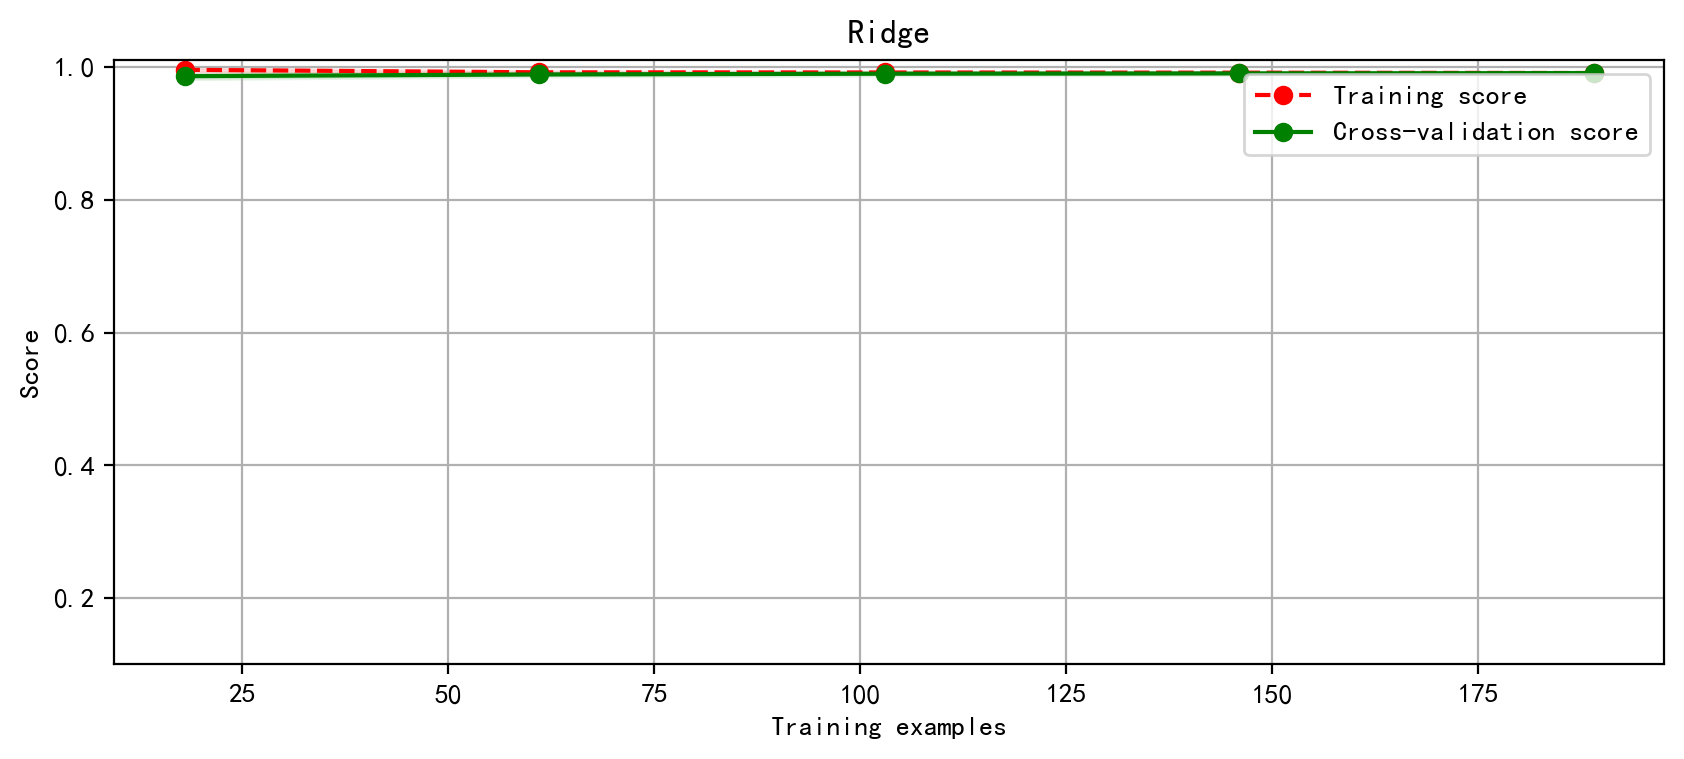

In [25]:
import time
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from common.utils import plot_learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn import svm

#model = LinearRegression()
model = Ridge (alpha = .5)
start = time.perf_counter()
model.fit(X_train, y_train)


train_score = model.score(X_train, y_train)
cv_score = model.score(X_test, y_test)
print('elaspe: {0:0.6f}; train_score: {1:0.6f}; cv_score: {2:0.6f}'.format(time.perf_counter()-start, train_score, cv_score))

plt.figure(figsize=(10,4),dpi=200)
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plot_learning_curve(plt, Ridge(), "Ridge", X, y, ylim=(0.1, 1.01), cv=cv)
#参数不能过多，过多会过拟合 高方差，含义是现有数据拟合很好，新数据拟合误差大
plt.show()

elaspe: 1.373472; train_score: 0.993690; cv_score: 0.991389


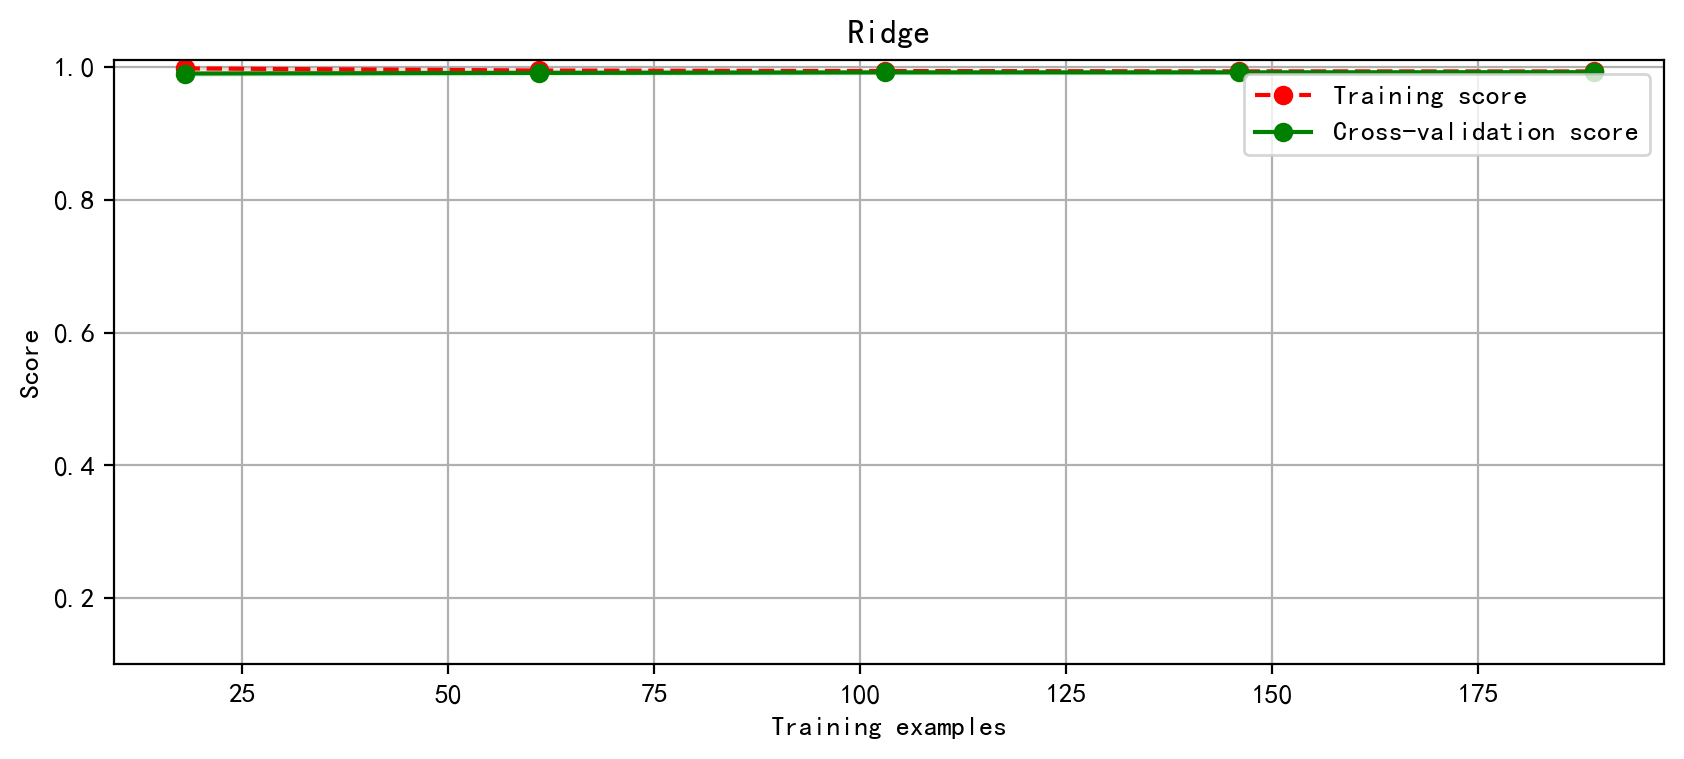

In [26]:
#model = LinearRegression()
z_model = Ridge (alpha = .5)
z_start = time.perf_counter()
z_model.fit(V_train, z_train)


z_train_score = z_model.score(V_train, z_train)
z_cv_score = z_model.score(V_test, z_test)
print('elaspe: {0:0.6f}; train_score: {1:0.6f}; cv_score: {2:0.6f}'.format(time.perf_counter()-start, z_train_score, z_cv_score))

plt.figure(figsize=(10,4),dpi=200)
z_cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plot_learning_curve(plt, Ridge(), "Ridge", V, z, ylim=(0.1, 1.01), cv=z_cv)
#参数不能过多，过多会过拟合 高方差，含义是现有数据拟合很好，新数据拟合误差大
plt.show()

预测最高价：
[49.50158937 49.07726844 52.32806268 49.14001554 51.48556888 52.92160291
 53.79023708]

预测最低价：
[47.32106183 47.11705466 49.12477244 46.79936476 49.0844278  50.82060184
 51.47953766]


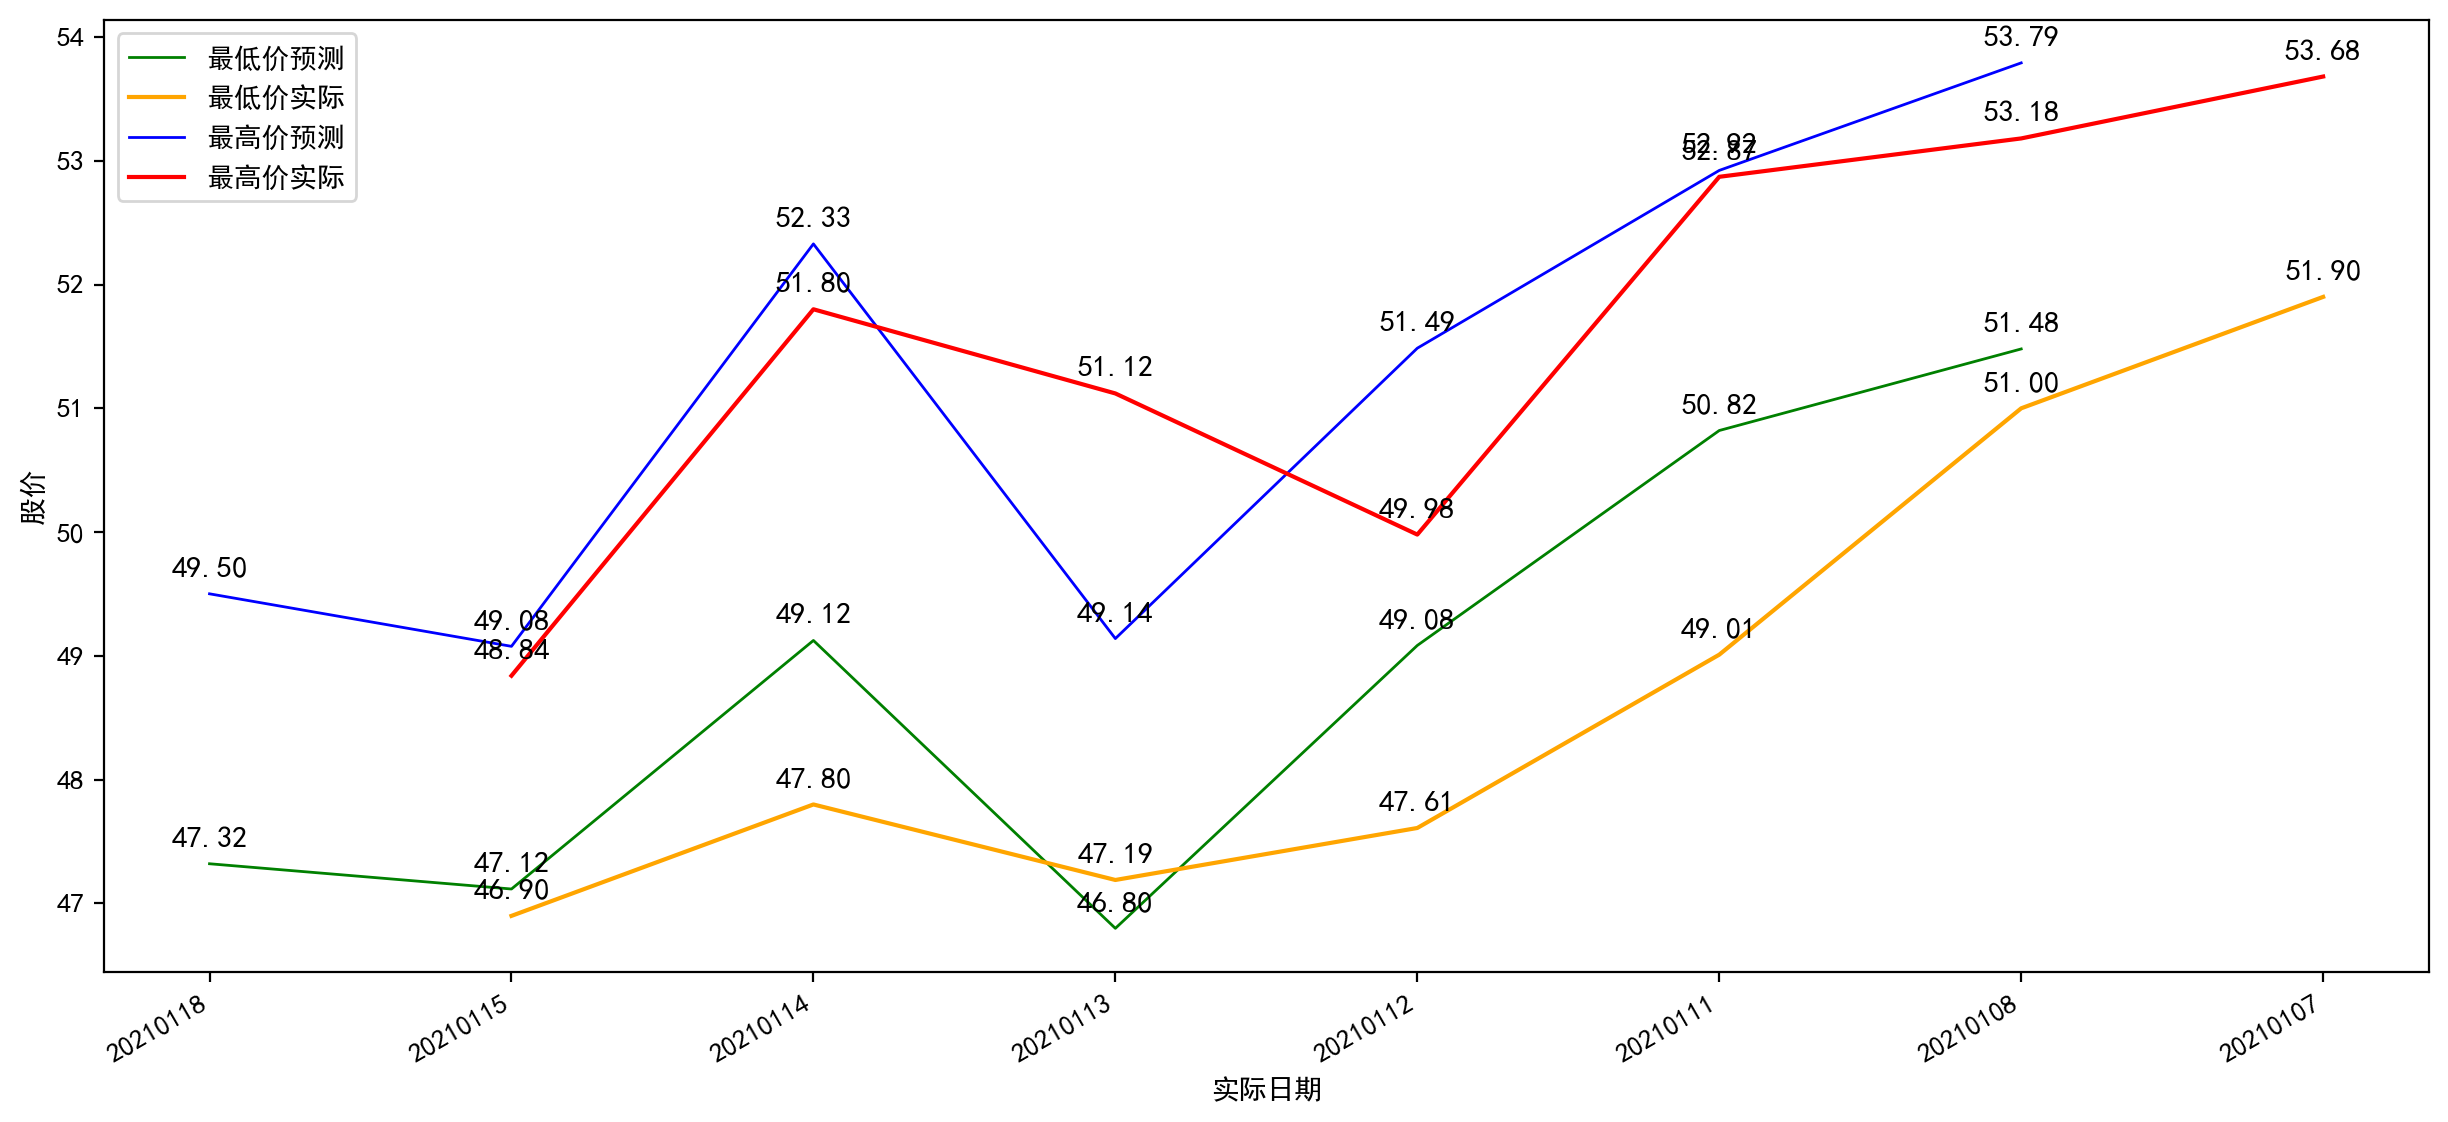

In [27]:
import matplotlib.dates as mdate

#预测数据 
p_da = pro.daily(ts_code=_tscode, start_date=dt3.strftime("%Y%m%d"), end_date=dt4.strftime("%Y%m%d"))

p_db = pro.daily_basic(ts_code=_tscode,start_date=dt3.strftime("%Y%m%d"),end_date=dt4.strftime("%Y%m%d"))
sub_p_db= p_db.loc[:,['trade_date','turnover_rate','volume_ratio']]
df2=dp.merge(p_da,sub_p_db)

#预测的是 daily + 1日期的数据
#删除日期列，日期列跨年引起预测数据巨大差异
df3 = df2[:].drop(['ts_code','trade_date'],axis=1)
df3.fillna(0,inplace=True)
#print(df3)

##############最高价显示##############
X_train_1 = model.predict(df3)
print('预测最高价：')
print(X_train_1)
print()
Z_train_1 = z_model.predict(df3)
print('预测最低价：')
print(Z_train_1)

#图形显示
plt.rcParams['font.family']=['sans-serif']
plt.rcParams['font.sans-serif']=['SimHei'] 

fig, ax = plt.subplots(figsize=(15,7),dpi=200)

y1 = X_train_1
y2 = p_da[:]['high']

#获取预测用日线行情当前日期
str_dt = p_da.iloc[0]['trade_date']
end_dt = datetime.datetime.strptime(str_dt, '%Y%m%d')+datetime.timedelta(days=+30)
#print(end_dt)

str_dt =  p_da.iloc[(p_da.iloc[:,0].size)-1]['trade_date']
start_dt = datetime.datetime.strptime(str_dt, '%Y%m%d')
#print(start_dt)

#x1 预测日期 ,x2 实际日期
df_c = pro.query('trade_cal', start_date=start_dt.strftime("%Y%m%d"),end_date=end_dt.strftime("%Y%m%d"),is_open=1)
#dataframe 倒排序 .iloc[::-1]
x1 = df_c.iloc[::-1][(df_c['cal_date'].size - df3['high'].size -1 ):-1]['cal_date'].values
#print(x1)
x2 = df_c.iloc[::-1][(df_c['cal_date'].size - df3['high'].size):]['cal_date'].values
#print(x2)


y3 = Z_train_1
y4 = p_da[:]['low']
x3 = df_c.iloc[::-1][(df_c['cal_date'].size - df3['low'].size -1 ):-1]['cal_date'].values
#print(x1)
x4 = df_c.iloc[::-1][(df_c['cal_date'].size - df3['low'].size):]['cal_date'].values
#print(x2)

plt.plot(x3,y3, color='green', linewidth=1, label='最低价预测')
for a,b in zip(x3,y3):
    plt.text(a,b+0.1,'%.2f'%b,ha = 'center',va = 'bottom',fontsize=11)

plt.plot(x4,y4, color='orange', linewidth=1.5,label='最低价实际')
for a,b in zip(x4,y4):
    plt.text(a,b+0.1,'%.2f'%b,ha = 'center',va = 'bottom',fontsize=11)

plt.plot(x1,y1, color='blue', linewidth=1, label='最高价预测')
for a,b in zip(x1,y1):
    plt.text(a,b+0.1,'%.2f'%b,ha = 'center',va = 'bottom',fontsize=11)

plt.plot(x2,y2, color='red', linewidth=1.5,label='最高价实际')
for a,b in zip(x2,y2):
    plt.text(a,b+0.1,'%.2f'%b,ha = 'center',va = 'bottom',fontsize=11)
    
plt.xlabel('实际日期')
plt.ylabel('股价')

plt.legend() 
plt.gcf().autofmt_xdate()
plt.show()



In [28]:
#每日收盘执行，将当日预测价格保存
from sqlalchemy import create_engine,Table, Column, Integer, String, Float, Date, MetaData, ForeignKey
from sqlalchemy.sql import select

engine = create_engine('sqlite:///D:\\workspace\\600754.db?check_same_thread=False', echo=True)
print(engine)
metadata = MetaData()
daily_forecast = Table('daily_forecast', metadata,
              Column('id', Integer, primary_key=True),
              Column('ts_code', String),
              Column('trade_date', String),
              Column('high',Float),
              Column('forecast_high',Float),
              Column('low',Float),
              Column('forecast_low',Float)
     )


conn = engine.connect()
ins = daily_forecast.insert().values(ts_code=df2['ts_code'][0],
                            trade_date=df2['trade_date'][0],
                            high=df2['high'][0],
                            forecast_high=X_train_1[1],
                            low=df2['low'][0],
                            forecast_low=Z_train_1[1]
                           )
#print(df2)
print(ins.compile().params)
result = conn.execute(ins)

Engine(sqlite:///D:\workspace\600754.db?check_same_thread=False)
2021-01-15 16:33:58,403 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2021-01-15 16:33:58,405 INFO sqlalchemy.engine.base.Engine ()
2021-01-15 16:33:58,414 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2021-01-15 16:33:58,415 INFO sqlalchemy.engine.base.Engine ()
{'ts_code': '600754.SH', 'trade_date': '20210115', 'high': 48.84, 'forecast_high': 49.077268442700934, 'low': 46.9, 'forecast_low': 47.11705465829094}
2021-01-15 16:33:58,419 INFO sqlalchemy.engine.base.Engine INSERT INTO daily_forecast (ts_code, trade_date, high, forecast_high, low, forecast_low) VALUES (?, ?, ?, ?, ?, ?)
2021-01-15 16:33:58,420 INFO sqlalchemy.engine.base.Engine ('600754.SH', '20210115', 48.84, 49.077268442700934, 46.9, 47.11705465829094)
2021-01-15 16:33:58,427 INFO sqlalchemy.engine.base.Engine COMMIT
